In [1]:
from pathlib import Path
from datetime import datetime as dt
import pandas as pd
import csv
import numpy as np
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
print(tf.__version__)

1.6.0


In [80]:
def read_dataset(dataset):
    path="dataset/VQAMed2018"+dataset+"/VQAMed2018"+dataset+"-QA.csv"
    df =pd.read_csv(path, sep='\t', header=None, quoting=csv.QUOTE_NONE)
    df = df.rename(columns={0: 'id', 1: 'image_name', 2:"question", 3:"answer"})
    print(dataset+" data size=",len(df))
    images = []
    for i in df["image_name"]:
        fname = "dataset/VQAMed2018"+dataset+"/VQAMed2018"+dataset+"-images/"+i+".jpg"
        images.append(fname)
    
    return images, df["question"], df["answer"]


In [81]:
val_images, val_questions, val_answers = read_dataset("Valid")
train_images, train_questions, train_answers = read_dataset("Train")

Valid data size= 500
Train data size= 5413


In [82]:
id=0
print (train_images[id], "\n", train_questions[id], "\n",train_answers[id] )

dataset/VQAMed2018Train/VQAMed2018Train-images/rjv03401.jpg 
 what does mri show? 
 lesion at tail of pancreas


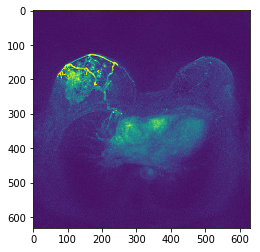

In [83]:
import matplotlib.image as mpimg

fname = val_images[3]
img=mpimg.imread(fname)
plt.imshow(img)

In [84]:
img

array([[255, 250, 251, ..., 255, 254, 254],
       [252, 253, 255, ..., 255, 255, 255],
       [255, 252, 192, ..., 199, 199, 198],
       ...,
       [255, 223,  20, ...,  20,  22,  19],
       [255, 223,  19, ...,  17,  19,  16],
       [254, 221,  16, ...,  10,  12,   9]], dtype=uint8)